In [219]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.figure_factory as ff
import copy
import category_encoders as ce
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import chi2

## Chapter 1 Load Data

In [220]:
data=pd.read_csv(r'C:\Users\DAVID SEO\Desktop\data_practice\homeless-dataset\homeless_prep.csv')

In [195]:
data.head()
data=data.drop('CLIENT_KEY',axis=1)
columns={'CLIENT_KEY':'client_key','AGE':'age','GENDER':'gender','VETERAN':'veteran','INCOME':'income','NIGHTS':'nights'}
data=data.rename(columns=columns)

## Chapter 2 Statical Measures 

In [196]:
def statistical_measure(data):
    test=[['Feature','Type','NA availability','Missing_Ratio','Skewness','Kurtosis']]
    for i in data.columns:
        column_name=i
        if data[i].dtype=='O':
            column_type='Object'
        else:
            column_type=data[i].dtype
        if data[i].isnull().sum()==0:
            missing_data='None'
            missing_ratio=0
        else:
            missing_data='Yes'
            missing_ratio=round(data[i].isnull().sum()/data[i].shape[0],2)
        if data[i].dtype=='O':
            skew='Not Applicable'
            kurtosis='Not Applicable'
        else:
            skew=round(data[i].skew(),2)
            kurtosis=round(data[i].kurt(),2)
        test.append([column_name,column_type,missing_data,missing_ratio,skew,kurtosis])
    return test
        
        
        
    

In [197]:
ff.create_table(statistical_measure(data))

In [198]:
data.describe()


,age,income,nights,substanceabuse,completed,probation,required
count,242.000000,242.000000,236.000000,242.000000,242.000000,242.000000,242.000000
mean,40.876033,661.549669,105.067797,0.314050,0.818182,0.280992,0.685950
std,14.791256,1221.773516,98.680980,0.465098,0.386494,0.450415,0.465098
min,20.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,0.000000,44.000000,0.000000,1.000000,0.000000,0.000000
50%,37.000000,571.000000,90.000000,0.000000,1.000000,0.000000,1.000000
75%,49.000000,906.000000,105.000000,1.000000,1.000000,1.000000,1.000000
max,79.000000,12583.340000,524.000000,1.000000,1.000000,1.000000,1.000000


 There seems to be a need to convert some of integer features into categorical varaibles since they are binary. 


In [199]:
features=['substanceabuse','completed','probation','required']
for i in features:
    data[i]=data[i].map(lambda x: 'No'if x==0 else 'Yes')


In [200]:
data2.head()

,gender,Female,Male
veteran,probation,,
No,Yes,148,18
Yes,Yes,20,18


In [201]:
content=[['Features','Elements']]
#store the categorical data and its unique memebers
for i,j in zip(data.columns,data.dtypes):
    if j=='object':
        content.append([i,list(data.loc[:,i].unique())])  
#present the result in the tablet format
ff.create_table(content).show()

### Comments:

There are some input features we may think that need to be manipulated before comprehensive analysis proceeds.As for the skewness of distribution data,  income is the one that presents the highest value, 7.83, and is spread out to the right of the mean, which means positively asymmetrical. The atypical number is understanding since a vast number of the homeless are more likely to earn a little or no income. And it also shows a piece of strong evidence that the data itself has some outliers we should remove, otherwise disrupting the rightness of our analysis. The same goes for nights but thier numbers are relatively smaller thant those of income.

We should take the visualization task to see if further jobs including filtering, modifying, and so on are required.

## Chapter 3 Detailed Investigation on Features

In [202]:
#Converting Categorical data into integer
ml_data=data.copy()
for i,j in enumerate(ml_data.dtypes):
    if j=='object' or 'category':
        ce_ord=ce.OrdinalEncoder()
        ml_data.iloc[:,i]=ce_ord.fit_transform(ml_data.iloc[:,i])



In [203]:
ml_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 10 columns):
age               242 non-null int64
gender            242 non-null int32
veteran           242 non-null int32
income            242 non-null float64
nights            236 non-null float64
substanceabuse    242 non-null int32
completed         242 non-null int32
probation         242 non-null int32
assistancetype    242 non-null int32
required          242 non-null int32
dtypes: float64(2), int32(7), int64(1)
memory usage: 12.4 KB


### - Income Level and Nights Staying At Shelters

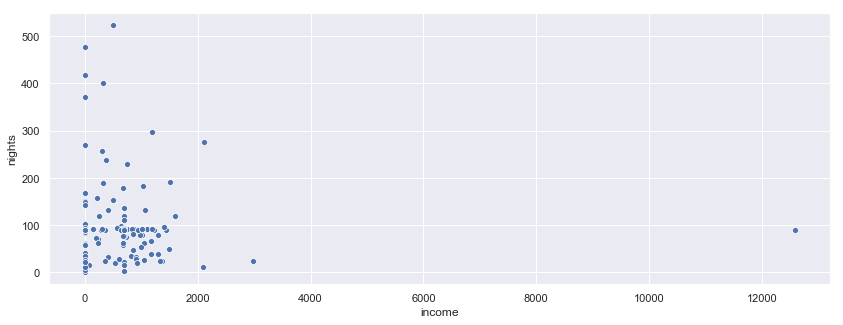

In [204]:
sns.set()
fig,ax=plt.subplots(figsize=(14,5))
sns.scatterplot(ml_data.income,ml_data.nights)

From the scatter plot,  we can notice that some observations are to be undoubtedly treated located far from  clusters, eventually disrupting our upcoming analysis.  First, to prevent this from happening, we should limit our scope to an income of fewer than 2000 dollars.  Furthermore,  a vast number of homeless are not stying more than 300 days regardless of income level. However, some of the observations stayed at shelters for a relatively long period.  We also take them as unusual and have them removed from our analysis. 

In [205]:
ml_data=ml_data[(ml_data.income<2000)&(ml_data.nights<300)]
ml_data.shape[0]
print('Number of Observations before filtering:{0}'.format(data.shape[0]))
print('Number of Observations After filtering: {0}'.format(ml_data.shape[0]))

Number of Observations before filtering:242
Number of Observations After filtering: 216


### - Income Level Combined with Veteran and  Nights Staying At Shelters

Sometimes, coming more than two features together could bring us unexpected results, helping us to have a better insight into the given data. This practice is mostly subjective to individual preference and experience.  Generally, we combine two columns highly correlated to each other. We reasonably think that there is an increase of income-level if he or she has some work experience in thier life time.

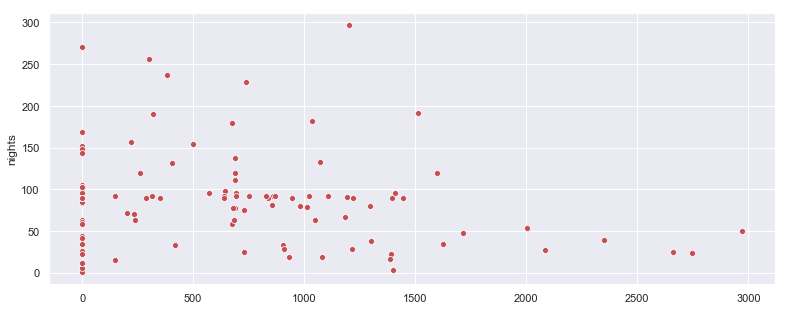

In [206]:
income_veteran=ml_data.income*ml_data.veteran
sns.set()
fig,ax=plt.subplots(figsize=(13,5))
sns.scatterplot(income_veteran,ml_data.nights,ax=ax,color='r')


Now, log formed data  identified more outliers that our original data had been unable to detect. This is one of the benefits we could enjoy after merging two or more features. 

In [207]:
ml_data=ml_data[income_veteran<2000]
print('Number of Observations before filtering:{0}'.format(data.shape[0]))
print('Number of Observations After filtering: {0}'.format(ml_data.shape[0]))

Number of Observations before filtering:242
Number of Observations After filtering: 204


Other combinations of features are possible but we have already lost 15% of our data and treated them as outliers. To refine our data to the extreme  could give you a better result  based on our given data but pratical significance of the outcome is highly questionable since too much processed data invaraibly leads to adverse results. So, my decision here is to stop right here!

### Chapter 3 Treament of Missing Values

In [208]:
ml_data.isnull().any()

age               False
gender            False
veteran           False
income            False
nights            False
substanceabuse    False
completed         False
probation         False
assistancetype    False
required          False
dtype: bool

 Through the last section, we have accidentally eliminated missing values as well as outliers.Therefore, no further treatment of the null values is required. 

In [209]:
#Selecting only 'applicable' rows of original data
data=data.iloc[ml_data.index,:]
print('Number of Observation after filtering out ouliers: {0} rows'.format(data.shape[0]))

Number of Observation after filtering out ouliers: 204 rows


### Chapter 3 EDA(Exploratory Data Analysis)

### 3.1 Homeless Number By Gender
 

Text(0.5, 1.0, 'Bar Chart For Homeless By Gender')

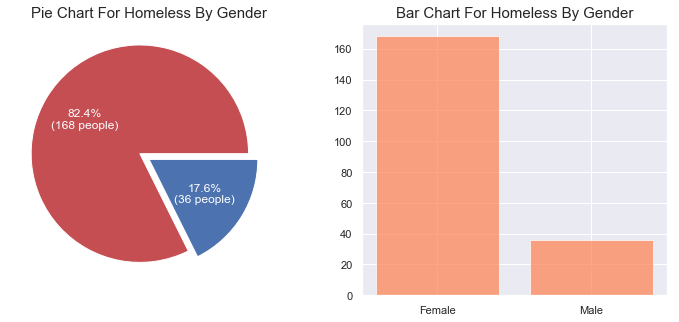

In [210]:
sns.set()
pie=data.groupby('gender')['age'].count()
fig,axes=plt.subplots(1,2,figsize=(12,5))
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} people)".format(pct, absolute)
axes[0].pie(pie, autopct=lambda x: func(x, pie),textprops=dict(color="w"),colors=['R','B'],explode=[0.1,0])
axes[0].set_title('Pie Chart For Homeless By Gender',fontsize=15)
axes[1].bar(x=pie.index,height=pie.values,color='coral',alpha=0.7)
axes[1].set_title('Bar Chart For Homeless By Gender',fontsize=15)


The number of homeless is dominant by females and thier figure is almost 4 times as large as that of males.  Let's look into what other factors may contribute to determining its rate.


### 3.2 Veteran homeless

![image](https://user-images.githubusercontent.com/53164959/67617736-3ba83780-f821-11e9-9338-ab37768ec09d.png)



In [211]:
data1=data.pivot_table('required',index='veteran',columns='gender',aggfunc='count',margins=True)
data2=data.pivot_table('required',index=['veteran','probation'],columns='gender',aggfunc='count',fill_value=0)
display(data1)
display(data2)

gender,Female,Male,All
veteran,,,
No,148,18,166
Yes,20,18,38
All,168,36,204


gender             Female  Male
veteran probation              
No      No            102    10
        Yes            46     8
Yes     No             18    18
        Yes             2     0

Text(0.5, 1.0, 'Numer of Homeless According to Veteran and Supervision over an offender Required')

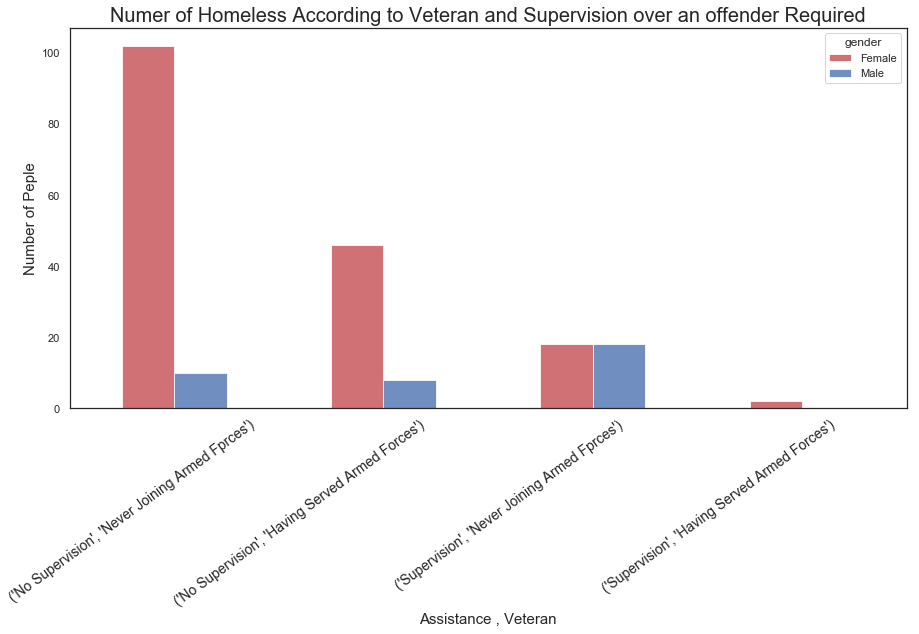

In [212]:
sns.set_style('white')
labels=[['No Supervision','Supervision'],['Never Joining Armed Fprces','Having Served Armed Forces']]
labels=list(pd.MultiIndex.from_product(labels))
fig,ax=plt.subplots(figsize=(15,7))
data2.plot(kind='bar',color=['R','B','Green'],ax=ax,alpha=0.8)
ax.set_xticks([-0.2,0.6,1.6,2.6])
ax.set_xticklabels(labels=labels,rotation=36,fontsize=14)
ax.set_xlabel('Assistance , Veteran',fontsize=15)
ax.set_ylabel('Number of Peple',fontsize=15)
ax.set_title('Numer of Homeless According to Veteran and Supervision over an offender Required',fontsize=20)


### Comments

The first table still shows that the majority of homeless consist of a female.  We take one step further to see if experience in committing a military service has affected our test results. The number of veterans is much lower in females since enlisted soldiers were men in the past. 

However, the veteran homeless is overrepresented where thier rate is almost 50% of the whole male homeless.  Bringing out some immediate measures for dealing with this social issue is urgent. 



### 3.2 Living Status and Gender

Table 1 :Living Status of Homeless By Gender


completed,No,Yes,All
gender,,,
Female,38,130,168
Male,0,36,36
All,38,166,204


Table 2: Average of Nights Acccording to Ceasing to Stay at Shelters and Gender 


completed,No,Yes
gender,,
Female,145.53,81.12
Male,0.00,59.61


Text(0, 0.5, 'Number of Nights')

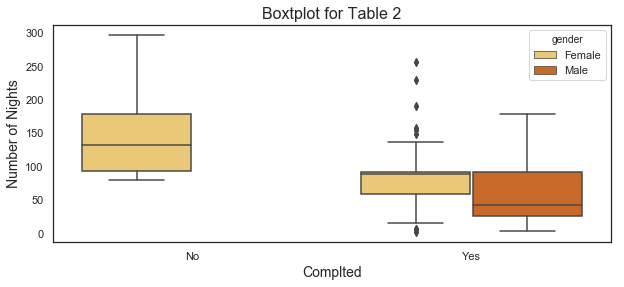

In [213]:
print('Table 1 :Living Status of Homeless By Gender')
display(data.pivot_table('nights',index='gender',columns='completed',aggfunc='count',fill_value=0,margins=True))

print('Table 2: Average of Nights Acccording to Ceasing to Stay at Shelters and Gender ')
display(round(data.pivot_table('nights',index='gender',columns='completed',aggfunc='mean',fill_value=0),2))

fig,ax=plt.subplots(figsize=(10,4))
sns.boxplot(x=data.completed,y=data.nights,hue=data.gender,palette='YlOrBr')
ax.set_title('Boxtplot for Table 2',fontsize=16)
ax.set_xlabel('Complted',fontsize=14)
ax.set_ylabel('Number of Nights',fontsize=14)

### Comments

Interestingly, most of the homeless decided to live thier staying at shelters at some point in time.  The second table reveals that the average hours of thier staying at the facility is l shorter for those completing thier staying which is quite obvious. On average, with respect to gender and cessation from living the facility, men end to live for a shorter period (approximately 22 days less) on average than women. 


### 3.3 probation and abuse (Chi-Square Test)


In [214]:
data.pivot_table('nights',index='substanceabuse',columns='probation',aggfunc='count',margins=True)

probation,No,Yes,All
substanceabuse,,,
No,112,32,144
Yes,36,24,60
All,148,56,204


It is well know that many individuals within crimiminal justice populations have serious substance use problems. This probably goes true for our case.  Those with no experience of substance abuse are more likely to be free from probation, which means less chance to violate the justice of laws.   The number with no prior record of abuse and supervision ordered by the court are quite high compared to other participants in this survey. 

If this is true, by providing the substance abuse treatment for the homeless, we could reduce the chance of their committing conduct against the rule of laws. Does this assertion gain a statistical significance? Let's find out if the statement sounds statistically reasonable!!



H<sub>O</sub> : The avability of substances are statistically independent from committment in crime .

H <sub>A</sub> : Substance abuse has a relation to the chance of conducting criminal activities.


The result rejects the null hypothesis and we can reach a conclusion that Substance abuse is somehow related to convicion. 


In [215]:
result=data.pivot_table('nights',index='substanceabuse',columns='probation',aggfunc='count')

# interpret test-statistic
def chi_square(data,prob):
    table=[['Test_Type','Critical Value','Alpha','p_value','Result']]
    stats,p,dof,expected=chi2_contingency(data)
    critical=chi2.ppf(prob,dof)
    alpha = 1.0 - prob
    if p <= alpha:
        result='Dependent (reject H0)'
    else:
        result='Independent (fail to reject H0)'
    outcome=['Chi_Square',critical,round(alpha,2),round(p,2),result]
    table.append(outcome)
    return table

ff.create_table(chi_square(result,0.95))


### 3.4 Interpretation of Features in terms of Age

In [216]:
data.age.describe()

count    204.000000
mean      40.784314
std       13.980724
min       20.000000
25%       31.000000
50%       37.500000
75%       48.000000
max       79.000000
Name: age, dtype: float64

In [217]:
labels=['20-29','30-39','40-49','50-59','over 60']
data['age_group']=pd.cut(data.age,bins=[19,29,39,49,59,data.age.max()],labels=labels)

In [218]:
data.pivot_table('nights',index=['probation','completed'],columns='age_group',aggfunc='count',fill_value=0)

age_group            20-29  30-39  40-49  50-59  over 60
probation completed                                     
No        No             8      8      2      0        0
          Yes           10     50     26     24       20
Yes       No             8     10      2      0        0
          Yes           12     16      6      2        0

From the last section, we have already seen that most of the recipients of support case management service and decide to leave thier shelters. On top of that, the above table also reveals that the 'decent ' group demonstrates a much higher rate of completing the service than those in a period of supervision except for the group aged between 20 and 29.  Aged between 30 and 39 is the group with the highest number who successfully achieve the program. Many research suggests a variety of reasons for this incredible higher number compared to other groups,one of which most gain justification saying that those in the group are actively seeking out opportunities to rebuild thier careers. This willingness leads them to finish the program with a higher rate.